In [6]:
import os, glob, json, math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error, 
    median_absolute_error,
    explained_variance_score
)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import (
    LSTM, 
    Dense, 
    Dropout,
    Input, 
    LayerNormalization, 
    MultiHeadAttention, 
    GlobalAveragePooling1D
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

c:\Users\user\miniconda3\envs\project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def mase(y_true, y_pred, m=1):
    y_true, y_pred = np.asarray(y_true).flatten(), np.asarray(y_pred).flatten()
    n = y_true.size
    d = np.abs(np.diff(y_true, n=m)).sum() / (n - m + 1e-9)
    return np.abs(y_true - y_pred).mean() / (d + 1e-9)
def rmsle_safe(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true).flatten(), np.asarray(y_pred).flatten()
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[mask], y_pred[mask]
    y_true_clip = np.clip(y_true, 0, None)
    y_pred_clip = np.clip(y_pred, 0, None)
    return np.sqrt(mean_squared_error(np.log1p(y_true_clip), np.log1p(y_pred_clip)))

In [8]:
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true).flatten(), np.asarray(y_pred).flatten()
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true).flatten(), np.asarray(y_pred).flatten()
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9))


In [9]:
def evaluate_model(name, y_true, y_pred, result_list, baseline_rmse=None):
    y_true, y_pred = np.asarray(y_true).flatten(), np.asarray(y_pred).flatten()
    # ---- 清理 NaN / Inf ----
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() == 0:
        print(f"[WARN] {name} -> 全部資料點均無法用於計算指標！")
        return
    y_true, y_pred = y_true[mask], y_pred[mask]

    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
    mape  = safe_mape(y_true, y_pred)       
    smape_val = smape(y_true, y_pred)      
    r2    = r2_score(y_true, y_pred)
    md_ae = median_absolute_error(y_true, y_pred)
    ev    = explained_variance_score(y_true, y_pred)
    mase_v= mase(y_true, y_pred)
    rmsle_v = rmsle_safe(y_true, y_pred)

    skill = 1 - (rmse / baseline_rmse) if baseline_rmse is not None else None

    print(f"{name} -> MAE:{mae:.4f} | RMSE:{rmse:.4f} | MAPE:{mape:.2%} | "
          f"R2:{r2:.4f} | MdAE:{md_ae:.4f} | EV:{ev:.4f} | "
          f"MASE:{mase_v:.4f} | RMSLE:{rmsle_v:.4f}"
          + (f" | Skill:{skill:.4f}" if skill is not None else ""))

    result_list.append(dict(model=name, MAE=mae, RMSE=rmse, MAPE=mape,SMAPE=smape_val,
                            MdAE=md_ae, R2=r2, EV=ev,
                            MASE=mase_v, RMSLE=rmsle_v,
                            SkillScore=skill))


In [10]:
LookBackNum = 24
ForecastNum = 48
now = datetime.now().strftime("%Y-%m-%dT%H_%M_%SZ")
data_path = os.path.join(os.getcwd(), "ExampleTrainData(AVG)\\ExampleTrainData(AVG)")

features      = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']
target_power  = ['Power(mW)']

In [11]:
csv_files = glob.glob(os.path.join(data_path, "AvgDATA_*.csv"))
df_list = [pd.read_csv(fp, encoding='utf-8') for fp in csv_files]
data = pd.concat(df_list, ignore_index=True)

X_weather = data[features].values
y_power   = data[target_power].values

scaler = MinMaxScaler().fit(X_weather)
X_scaled = scaler.transform(X_weather)

In [12]:
X_p_seq, y_p_seq = [], []
for i in range(LookBackNum, len(y_power)):
    X_p_seq.append(y_power[i-LookBackNum:i, 0])
    y_p_seq.append(y_power[i, 0])
X_p_seq = np.array(X_p_seq).reshape(-1, LookBackNum, 1)
y_p_seq = np.array(y_p_seq)

# 5‒2 氣象 ➜ LSTM-2/3
X_seq, y_seq = [], []
for i in range(LookBackNum, len(X_scaled)):
    X_seq.append(X_scaled[i-LookBackNum:i])
    y_seq.append(X_scaled[i])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# 5‒3 氣象多步 ➜ LSTM-4
X_multi, y_multi = [], []
for i in range(LookBackNum, len(X_scaled) - ForecastNum):
    X_multi.append(X_scaled[i-LookBackNum:i])
    y_multi.append(X_scaled[i:i+ForecastNum])
X_multi = np.array(X_multi)
y_multi = np.array(y_multi)

In [13]:
def build_lstm(input_shape, out_dim):
    model = Sequential([
        LSTM(256, return_sequences=True, input_shape=input_shape),
        LSTM(128),
        Dropout(0.1),
        Dense(out_dim)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

In [14]:
lstm1 = build_lstm((LookBackNum, 1), 1)
lstm1.fit(X_p_seq, y_p_seq, epochs=10, batch_size=256, verbose=0)

c:\Users\user\miniconda3\envs\project\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
lstm2 = build_lstm((X_seq.shape[1], X_seq.shape[2]), len(features))
lstm2.fit(X_seq, y_seq, epochs=10, batch_size=256, verbose=0)

lstm_feat2 = lstm2.predict(X_seq)
y_cut      = y_power[LookBackNum:].flatten()

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4)
xgb.fit(lstm_feat2, y_cut)

2406/2406 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
lstm3 = build_lstm((X_seq.shape[1], X_seq.shape[2]), len(features))
lstm3.fit(X_seq, y_seq, epochs=10, batch_size=256, verbose=0)

lstm_feat3 = lstm3.predict(X_seq)
lr = LinearRegression().fit(lstm_feat3, y_cut)

2406/2406 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step


In [17]:
lstm4 = build_lstm((LookBackNum, X_scaled.shape[1]), X_scaled.shape[1] * ForecastNum)
lstm4.fit(X_multi, y_multi.reshape(-1, X_scaled.shape[1]*ForecastNum),
          epochs=10, batch_size=128, verbose=0)

lstm_feat4 = lstm4.predict(X_multi)\
              .reshape(-1, ForecastNum, len(features))[:, 0, :]
cat_y = y_power[LookBackNum+ForecastNum : LookBackNum+ForecastNum+len(lstm_feat4)].flatten()

cb = CatBoostRegressor(iterations=300, depth=6, learning_rate=0.05, verbose=0)
cb.fit(lstm_feat4, cat_y)

c:\Users\user\miniconda3\envs\project\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2404/2404 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step


In [18]:
def build_transformer(input_shape,
                      d_model=32,        # 嵌入維度（越小越不易過擬合）
                      num_heads=2,       # 注意力頭數
                      ff_dim=128,         # Feed-Forward 網路維度
                      dropout=0.15):
    """
    Minimal Transformer Encoder → GlobalAveragePooling → Dense(1) regression head.
    只有 1 個 Encoder block，參數量約數千，適合小資料。
    """
    inp = Input(shape=input_shape)                       # (time_steps, features)

    # --- Encoder Block ---
    x = LayerNormalization(epsilon=1e-6)(inp)
    attn = MultiHeadAttention(num_heads=num_heads,
                              key_dim=d_model,
                              dropout=dropout)(x, x)
    x = Add()([x, attn])                                 # Skip Conn.

    x2 = LayerNormalization(epsilon=1e-6)(x)
    ff  = Dense(ff_dim, activation="relu")(x2)
    ff  = Dense(d_model)(ff)
    x   = Add()([x, ff])                                 # Skip Conn.

    # --- Pool & Regression Head ---
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)

    model = Model(inp, out, name="MiniTransformer")
    model.compile(optimizer="adam", loss="mae")
    return model


In [19]:
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D, Add
)
from tensorflow.keras.models import Model

In [20]:
# -------------------------------
# Transformer (Power only) 模型
# -------------------------------
from tensorflow.keras.callbacks import EarlyStopping
trans = build_transformer(input_shape=(LookBackNum, 1),
                          d_model=16, num_heads=2, ff_dim=32, dropout=0.15)

early_stop = EarlyStopping(monitor="loss",
                           patience=10, restore_best_weights=True)

trans.fit(X_p_seq, y_p_seq,
          epochs=50,         # 小資料 → 多跑幾輪並早停
          batch_size=256,
          callbacks=[early_stop],
          verbose=0)
y_pred_trans = trans.predict(X_p_seq).flatten()

2406/2406 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [49]:
results = []
evaluate_model("LSTM", y_p_seq, lstm1.predict(X_p_seq), results)
evaluate_model("LSTM+XGBoost",   y_cut,   xgb.predict(lstm_feat2), results)
evaluate_model("LSTM+Linear",    y_cut,   lr.predict(lstm_feat3),  results)
evaluate_model("LSTM+CatBoost",  cat_y,   cb.predict(lstm_feat4),  results)
evaluate_model("Transformer", y_p_seq, y_pred_trans, results)

2406/2406 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step
LSTM -> MAE:247.4713 | RMSE:491.5894 | MAPE:63.98% | R2:0.1816 | MdAE:14.3793 | EV:0.3577 | MASE:2.6902 | RMSLE:0.9607
LSTM+XGBoost -> MAE:124.0903 | RMSE:231.5987 | MAPE:968.33% | R2:0.8184 | MdAE:35.8612 | EV:0.8184 | MASE:1.3490 | RMSLE:1.2447
LSTM+Linear -> MAE:158.1998 | RMSE:259.7743 | MAPE:1953.88% | R2:0.7715 | MdAE:80.9736 | EV:0.7715 | MASE:1.7198 | RMSLE:1.2745
LSTM+CatBoost -> MAE:305.1087 | RMSE:435.6906 | MAPE:4367.96% | R2:0.3572 | MdAE:176.1066 | EV:0.3572 | MASE:3.3174 | RMSLE:2.2640
Transformer -> MAE:350.1238 | RMSE:626.5475 | MAPE:1505.62% | R2:-0.3294 | MdAE:51.2400 | EV:0.0000 | MASE:3.8061 | RMSLE:2.1946


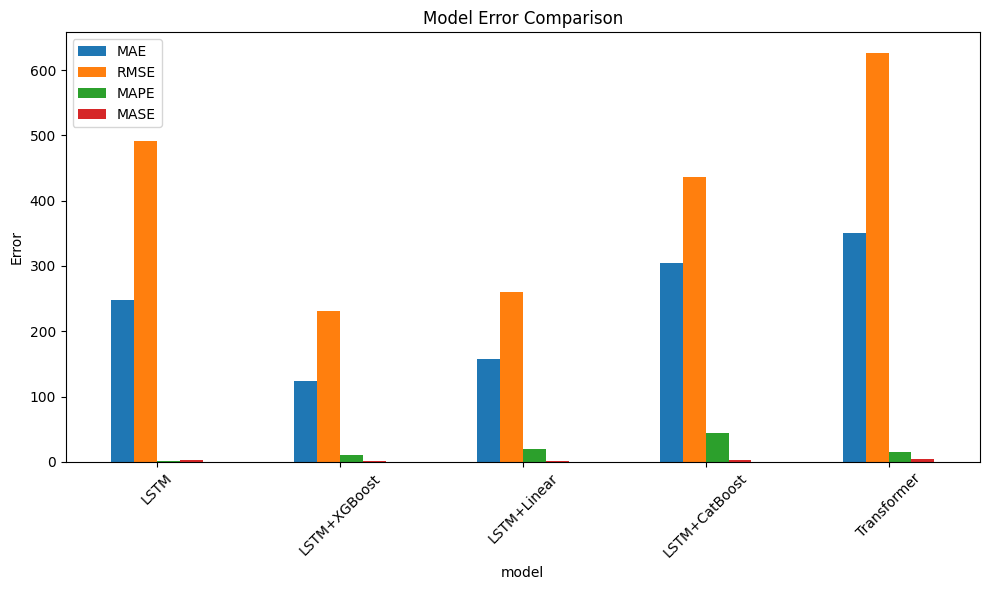

In [50]:
df = pd.DataFrame(results).set_index("model")

# 8‒1 多指標長條圖
df[["MAE", "RMSE", "MAPE", "MASE"]].plot(kind="bar", figsize=(10,6), rot=45,
                                         title="Model Error Comparison")
plt.ylabel("Error")
plt.tight_layout()
plt.savefig(f"model_errors_{now}.png")
plt.show()

In [51]:
if df["SkillScore"].notna().any():
    labels = df.index.tolist()
    scores = df["SkillScore"].fillna(0).values
    angles = np.linspace(0, 2*math.pi, len(labels), endpoint=False)
    scores = np.concatenate([scores, [scores[0]]])
    angles = np.concatenate([angles, [angles[0]]])

    fig = plt.figure(figsize=(5,5))
    ax  = fig.add_subplot(111, polar=True)
    ax.plot(angles, scores, marker='o')
    ax.fill(angles, scores, alpha=0.25)
    ax.set_thetagrids(angles[:-1]*180/math.pi, labels)
    ax.set_title("Skill Score (higher = better)")
    plt.tight_layout()
    plt.savefig(f"skill_score_{now}.png")
    plt.show()

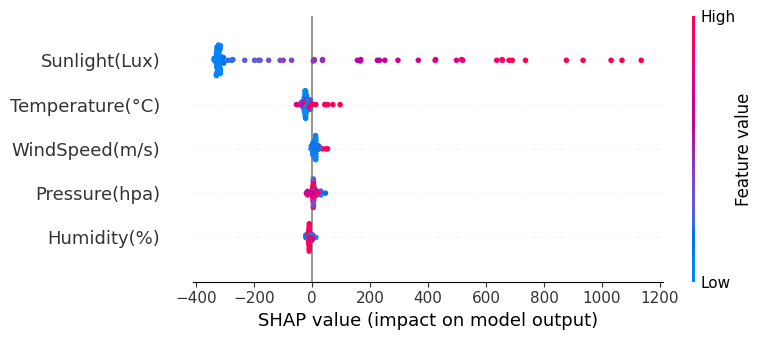

In [52]:
explainer = shap.Explainer(xgb)
shap_values = explainer(lstm_feat2[:100])
shap.summary_plot(shap_values,
                  features=lstm_feat2[:100],
                  feature_names=features,
                  show=False)
plt.tight_layout()
plt.savefig(f"shap_summary_{now}.png")
plt.show()

In [53]:
df = pd.DataFrame(results).set_index("model").sort_index()
plt.rc("mathtext", default="regular")

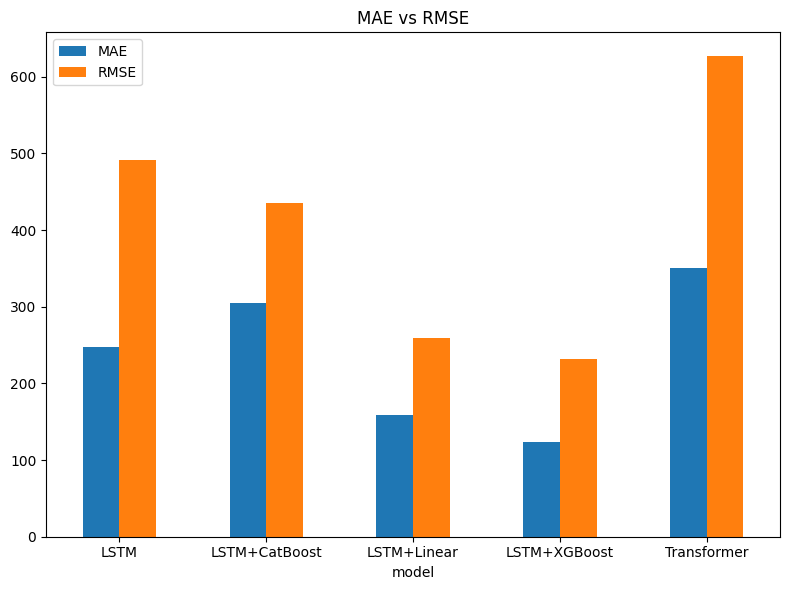

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
df[["MAE","RMSE"]].plot(kind="bar", ax=ax)
ax.set_title("MAE vs RMSE"); ax.set_xticklabels(df.index, rotation=0)
plt.tight_layout(); plt.show()

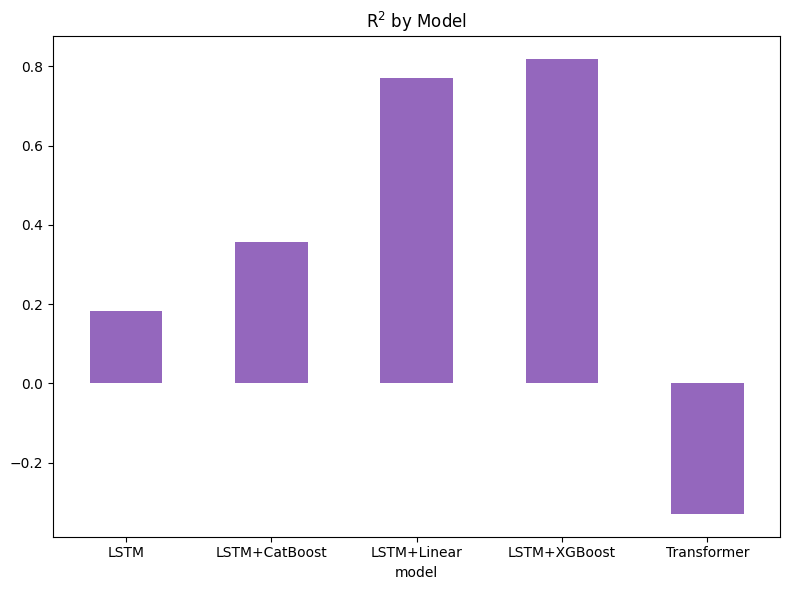

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
df["R2"].plot(kind="bar", ax=ax, color="tab:purple")
ax.set_title(r"$R^2$ by Model"); ax.set_xticklabels(df.index, rotation=0)
plt.tight_layout(); plt.show()

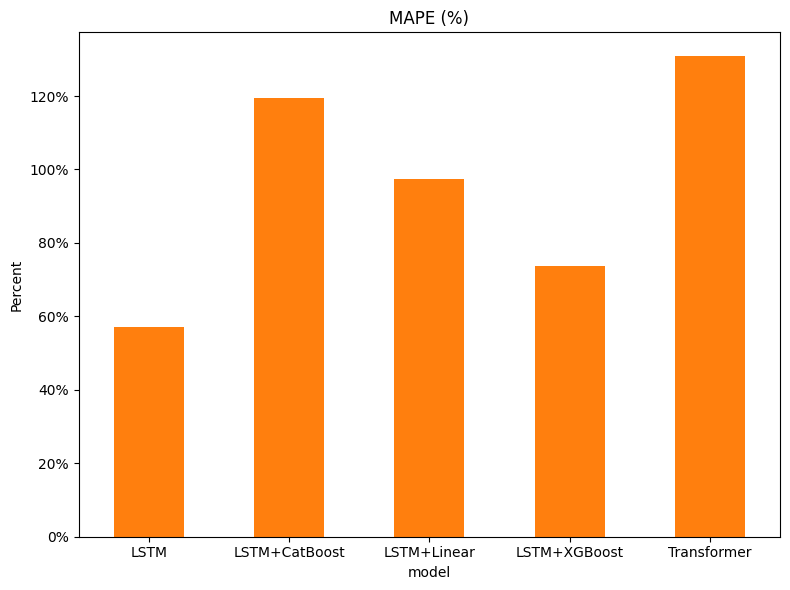

In [56]:
fig, ax = plt.subplots(figsize=(8,6))
# 如果用 safe MAPE：
#(df["MAPE"] * 100).plot(kind="bar", ax=ax, color="tab:green")
# 或用 SMAPE：
(df["SMAPE"] * 100).plot(kind="bar", ax=ax, color="tab:orange")
ax.set_title("MAPE (%)"); ax.set_ylabel("Percent"); ax.set_xticklabels(df.index, rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout(); plt.show()

In [40]:
import pandas as pd

In [30]:
# 讀取CSV檔案成為DataFrame
define = pd.read_csv('AI CUP 2024\ExampleTrainData(AVG)\AvgDATA_01.csv')

# 印出前五列
define.head(10)

,Serial,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,20240101090001,1.92,1017.91,18.33,92.29,8395.25,17.37
1,20240101091001,0.09,1017.96,18.02,97.37,7046.50,12.61
2,20240101092001,0.02,1018.16,17.73,99.93,5919.58,8.81
3,20240101093001,0.02,1018.20,17.90,100.00,8838.92,17.56
4,20240101094001,0.04,1018.13,18.08,100.00,5774.67,7.51
5,20240101095001,0.02,1018.03,17.83,100.00,5437.75,7.03
6,20240101100001,0.00,1018.04,17.75,100.00,9312.75,19.71
7,20240101101001,0.04,1017.87,17.99,100.00,9500.67,20.35
8,20240101102001,0.02,1017.82,18.13,100.00,9711.58,20.43
9,20240101103001,0.01,1017.82,18.20,100.00,7952.50,14.01
